In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import optuna
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from phik import phik_matrix
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
import pmdarima

import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

In [90]:
df = pd.read_csv('paris_temperature.csv')

In [91]:
def preprocess_x(df):
    df['preciptype'].fillna(df['preciptype'].mode()[0], inplace=True)
    df['stations'].fillna(df['stations'].mode()[0], inplace=True)

    df['datetime'] = pd.to_datetime(df['datetime'])
    df['sunrise'] = pd.to_datetime(df['sunrise'])
    df['sunset'] = pd.to_datetime(df['sunset'])

    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofyear'] = df['datetime'].dt.dayofyear

    return df

In [92]:
def preprocess_y(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)

    return df

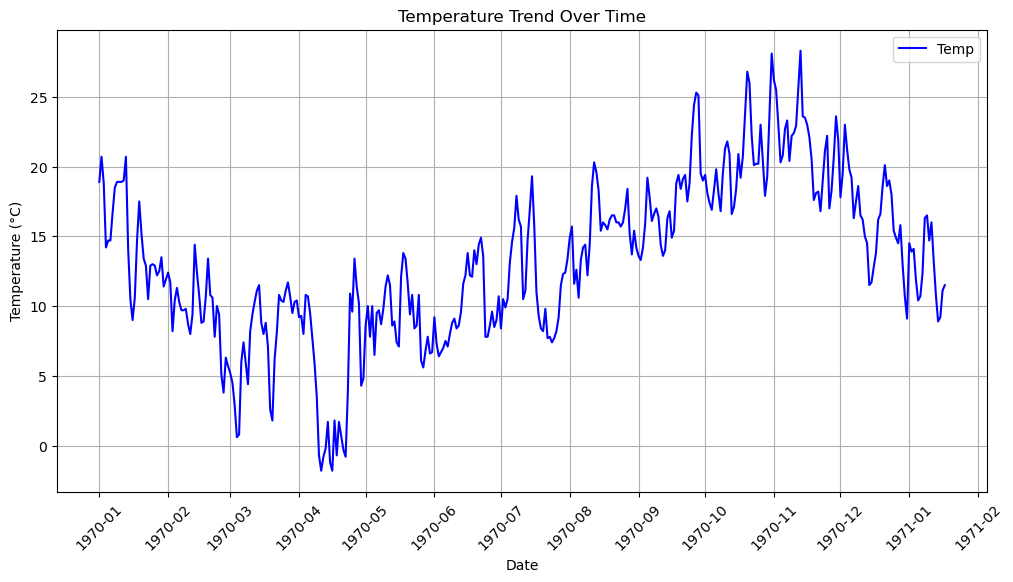

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temp'], label='Temp', color='blue', linestyle='-')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trend Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()



1. name:
* Meaning: Location where the weather data was collected.
* Value: "Paris,France"                                     
2. datetime
* Meaning: Date of the observation in datetime format. Helps in analyzing weather trends over time.
* Value: From "2023-10-01" to "2024-10-16"                                       
3. tempmax            
* Meaning: Maximum temperature recorded during the day, indicating the peak warmth for the day.                       
* Value: From -1.3 to 36.2     
* Unit : Celsius (C)                                   
4. tempmin             
* Meaning: Minimum temperature recorded during the day in degrees Celsius.         
* Value From -4.1 to 21.2    
* Unit : Celsius (C)                                     
5. temp               
* Meaning: Average daily temperature in degrees Celsius. Represents the mean temperature throughout the day.                             
* Value: From -1.8 to 28.3  
* Unit : Celsius (C)                                        
6. feelslikemax
* Meaning: Maximum perceived temperature (feels-like) in degrees Celsius, accounting for wind chill and humidity.
* Value: From -5.5 to 39      
* Unit : Celsius (C)                                   
7. feelslikemin
* Meaning: Minimum perceived temperature (feels-like) in degrees Celsius, providing insight into perceived coldest conditions.          
* Value: From -7.3 to 21.2     
* Unit : Celsius (C)                                    
8. feelslike
* Meaning: Average perceived temperature in degrees Celsius. Takes into account both wind chill and humidity for a more accurate feel.
* Value: From -6.3 to 29.6
* Unit : Celsius (C)                                          
9. dew   
* Meaning: Dew point temperature in degrees Celsius, showing the temperature at which air becomes saturated with moisture.                
* Value: From -6.1 to 20.3    
* Unit : Celsius (C)                                      
10. humidity          
* Meaning: Relative humidity percentage, showing the air's moisture level, with higher values indicating more moisture.                  
* Value: From 51.6 to 95   
* Unit: percentage (%).                                        
11. precip           
* Meaning: Total precipitation in millimeters, providing the total rainfall or snowfall for the day.                                      
* Value: From 0 to 25.008
* Unit: millimeters (mm).                                       
12. precipprob         
* Meaning: Probability of precipitation as a percentage, indicating the chance of rain or snow occurring during the day.                 
* Value : From 0 to 100 (0 for no precipitation)
* Unit: percentage (%)                       
13. precipcover        
* Meaning: Percentage of time precipitation was present during the day, describing the duration of rain or snow.                          
* Value: From 0 to 75 (0 for no precipitation)   
* Unit: percentage (%)                                   
14. preciptype          
* Meaning: Type of precipitation (rain, snow, etc.). Helps classify the form of precipitation for specific weather conditions.            
* Value: "rain", "rain,snow", "rain,freezing", empty for no precipitation           
15. snow                
* Meaning: Total snowfall in millimeters, indicating the amount of snow accumulated during the day.                                       
* Value: 0, 0.1, 0.2, 0.3, 0.6, 5.4                                         
16. snowdepth          
* Meaning: Snow depth in millimeters, representing the cumulative depth of snow on the ground.                                            
* Value: From 0.1 to 3.9, 0 for most days without snow                        
17. windgust            
* Meaning: Maximum wind gust speed in kilometers per hour, measuring sudden, short bursts of high wind.                                   
* Value: From 14.4 to 92.2
* Unit: kph.                                       
18. windspeed           
* Meaning: Average wind speed in kilometers per hour, providing an overview of general windiness during the day.                          
* Value: From 6.8 to 44.3  
* Unit: kilometers per hour (kph)                                       
19. winddir             
* Meaning: Average wind direction in degrees (0 to 360), indicating the prevailing wind direction.                                       
* Value: From 0.4 to 358.2 (compass degree). where 0° is north, 90° is east, 180° is south, and 270° is west.                                        
20. sealevelpressure    
* Meaning: Sea-level pressure in hPa, useful for understanding atmospheric pressure patterns that affect weather conditions.              
* Value: From 979.7 to 1042.8  
* Units: millibars (mb) or hectopascals (hPa)                                       
21. cloudcover          
* Meaning: Average cloud cover percentage, showing the extent of cloudiness throughout the day.                                           
* Value: From 13 to 100   
* Unit: percentage (%)                                         
22. visibility          
* Meaning: Average visibility distance in kilometers, showing how clear or obstructed the view is (e.g., fog reduces visibility).         
* Value: From 5.1 to 39.1  
* Unit: kilometers (km)                                       
23. solarradiation      
* Meaning: Average solar radiation in watts per square meter (W/m²), indicating the strength of solar energy reaching the surface.       
* Value : From 0 to 169.8
* Unit: watts per square meter (W/m²)                                           
24. solarenergy         
* Meaning: Total solar energy in megajoules per square meter (MJ/m²) received throughout the day. Useful for solar energy analysis.       
* Value: From 0.0 to 14.7  
* Unit: megajoules per square meter (MJ/m²)                                       
25. uvindex             
* Meaning: Maximum UV index for the day, indicating the level of ultraviolet radiation and potential risk of sunburn.                    
* Value: From 0 to 8 (integer value).Values typically range from 0 (low) to 11+ (extreme).                                            
26. severerisk          
* Meaning:  An indicator of the risk of severe weather events, such as thunderstorms or tornadoes         
* Value: may range from 0 (no risk) to higher numbers indicating greater risk.                                     
27. sunrise             
* Meaning: Time of sunrise in ISO format, providing the exact time the sun rises, which can vary with seasons.                           
* Value: ISO 8601 format "YYYY-MM-DDThh:mm:ss"                               
28. sunset              
* Meaning: Time of sunset in ISO format, indicating when the sun sets, which is essential for calculating daylight hours.                 
* Value: ISO 8601 format "YYYY-MM-DDThh:mm:ss"                               
29. moonphase           
* Meaning: Numeric representation of the moon phase, where 0 = new moon and 1 = full moon, affecting nighttime lighting.               
* Value: From 0 to 0.98  
The phase of the moon, represented as a value between 0 and 1. Values:
  - 0: New Moon
  - 0 to 0.25: Waxing Crescent
  - 0.25: First Quarter
  - 0.25 to 0.5: Waxing Gibbous
  - 0.5: Full Moon
  - 0.5 to 0.75: Waning Gibbous
  - 0.75: Last Quarter
  - 0.75 to 1: Waning Crescent                                        
30. conditions          
* Meaning: Brief summary of weather conditions, describing general weather patterns like rain or cloudiness.                             
* Value: "Clear", "Overcast", "Partially cloudly", "Snow, Rain, Freezing Drizzle", "Rain, Overcast", "Snow, Rain, Overcast", "Snow, Rain, Partially cloudly"                            
31. description         
* Meaning: Detailed text explaining the day’s weather, providing context about specific events like "morning showers."                   
* Value: Text describing weather of the day                
32. icon                
* Meaning: Icon code representing the weather visually (e.g., “rain”, “partly-cloudy-day”), useful for quick weather snapshots.        
* Value: "clear day", "rain", "snow", "cloudy", "partly-cloudy-day"                 
33. stations            
* Meaning: List of weather station IDs that provided data for the day, showing data sources for verification or comparison.            
* Value: CSV list of strings identifying the stations                          

##**Determine Numerical & Categorical Features**##

In [94]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical Features: ['name', 'datetime', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


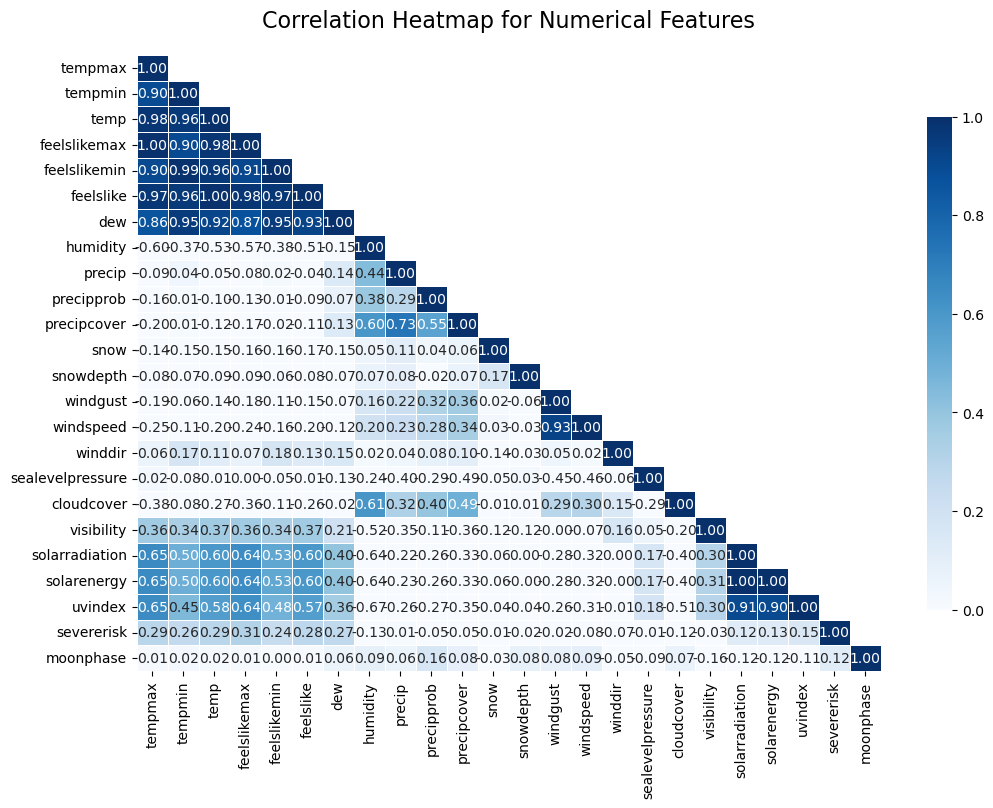

In [95]:
corr_matrix = df[numerical_features].corr()

mask = ~np.tril(np.ones(corr_matrix.shape, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,mask=mask, annot=True, fmt='.2f',  cmap='Blues',  vmax=1.0,
            vmin=0.0, cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title('Correlation Heatmap for Numerical Features', fontsize=16, pad=20)
plt.show()

interval columns not set, guessing: ['temp']


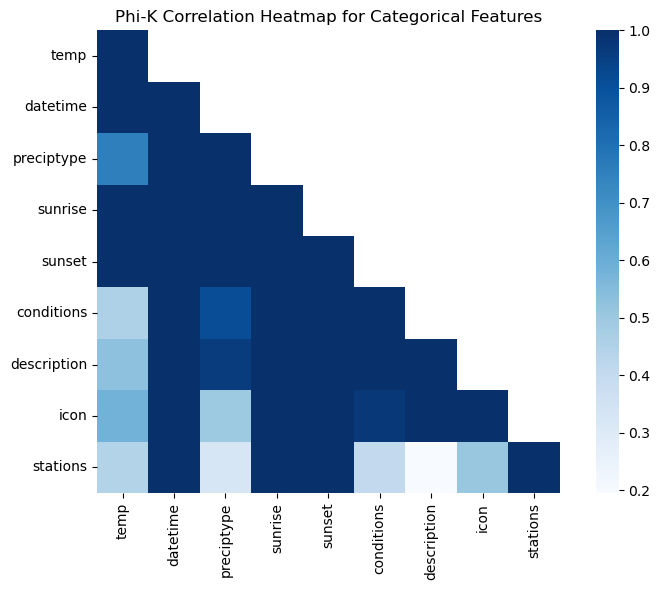

In [96]:
cols_for_phik = ['temp'] + categorical_features
phik_matrix = df[cols_for_phik].phik_matrix()

mask = np.triu(np.ones_like(phik_matrix, dtype=bool),k=1)
plt.figure(figsize=(8, 6))
sns.heatmap(
    phik_matrix,
    mask=mask,
    cmap="Blues",
    annot=False,
    cbar=True,
    square=True
)
plt.title("Phi-K Correlation Heatmap for Categorical Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

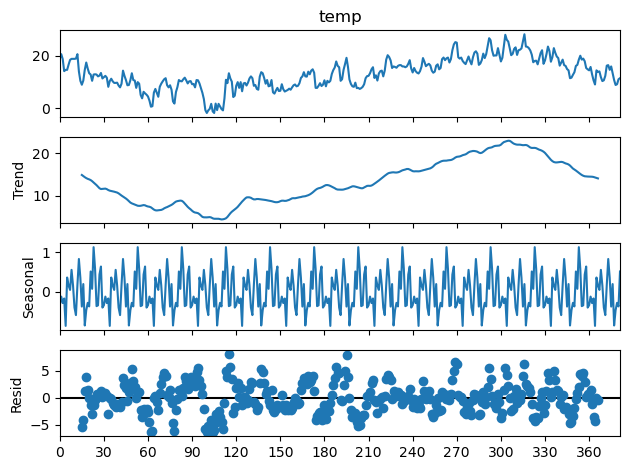

In [97]:
decompose = seasonal_decompose(df['temp'], model='additive', period=30)
decompose.plot()
plt.xticks(range(0, len(df), 30))
plt.show()

- In general: Even though there is fluctuations in short periods, it seems that the temperature does have an overall trend through long periods (months)
- Trend: The trend is not very clear, but we can see that there is a seasonal fluctuation: the temperature falls, then rises, and after a period starts to fall again
- Seasonal: The fluctuation is consistent over periods of time, indicating a good seasonal pattern
- Residual: There is indeed residuals in the dataset, but the fluctuation isn't too high. The fluctuation also doesn't have a trend, so there is no leftover factor that we haven't captured

In [98]:
seasonality_strength = (decompose.seasonal.var() / df['temp'].var()) * 100
print(f"Seasonality explains {seasonality_strength:.2f}% of the variance")

Seasonality explains 0.69% of the variance


#**Test for Stationarity**#

In [99]:
X=df['temp'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("Paris temperature is stationary (reject null hypothesis/no unit root).")
else:
    print("Paris temperature is non-stationary (fail to reject null hypothesis/unit root).")

ADF Statistic: -2.742623
p-value: 0.066949
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Paris temperature is non-stationary (fail to reject null hypothesis/unit root).


##**Differencing Operations**##

In [100]:
ndiffs(df.temp, test='adf')

1

=> The paris temperature is difference-stationary after first-order differencing

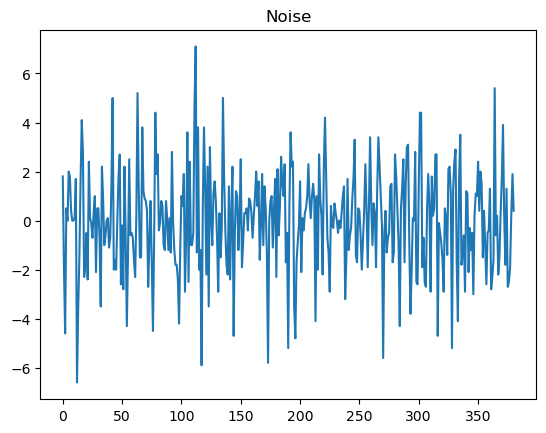

In [101]:
first_order_diff = pmdarima.arima.utils.diff(df.temp, lag=1, differences=1)
plt.plot(first_order_diff)
plt.title('Noise')
plt.show()

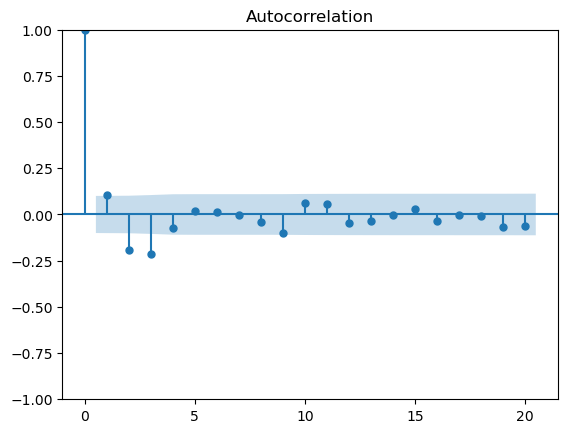

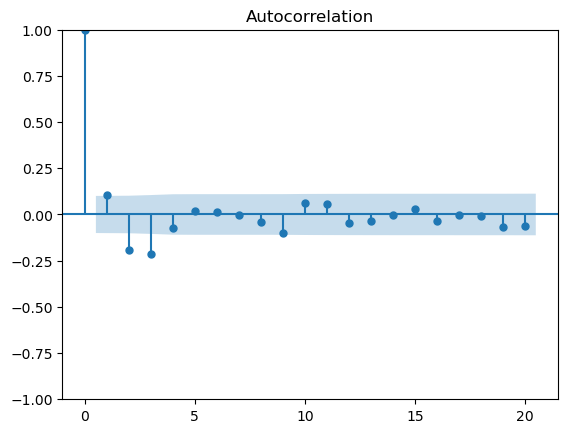

In [102]:
plot_acf(first_order_diff, lags=20)

In [103]:
ndiffs(first_order_diff, test='adf')

0

#**Prophet Model Quick Applying**#

In [104]:
df_train = df.loc[df['datetime'] <= '2024-09-15']
df_test = df.loc[df['datetime'] > '2024-09-15']
df_prophet_train = df_train[['datetime', 'temp']]
df_prophet_test = df_test[['datetime', 'temp']]

df_prophet_train.columns = ['ds', 'y']
df_prophet_test.columns = ['ds', 'y']

In [105]:
model = Prophet()

model.fit(df_prophet_train)

# Predict on test set dates
forecast_train = model.predict(df_prophet_train[['ds']])
forecast_test = model.predict(df_prophet_test[['ds']])

y_pred_train = forecast_train['yhat'].values
y_pred_test = forecast_test['yhat'].values

y_true_train = df_prophet_train['y'].values
y_true_test = df_prophet_test['y'].values

# Calculate metrics
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
r2_train = r2_score(y_true_train, y_pred_train)
mape_train = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100

rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2_test = r2_score(y_true_test, y_pred_test)
mape_test= np.mean(np.abs((y_true_test- y_pred_test) / y_true_test)) * 100


df_result = pd.DataFrame(data=[['Train set', rmse_train, r2_train, mape_train],[ 'Test set', rmse_test, r2_test, mape_test]],
                         columns=['Dataset', 'RMSE', 'R^2', 'MAPE'])

df_result

22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing


,Dataset,RMSE,R^2,MAPE
0,Train set,3.457923,0.666576,68.521670
1,Test set,8.900814,-7.307970,67.303419


##**Explanation of Metrics**##

- RMSE (Root Mean Squared Error): Measures the average deviation of predictions from actual values. A lower value indicates better accuracy.

- R² (R-squared or Coefficient of Determination): Measures how well the model explains the variance in actual data. A value close to 1 indicates a good fit, while a negative value means the model performs worse than a simple mean-based prediction.

- MAPE (Mean Absolute Percentage Error): Measures the percentage error on average. A lower value means better predictions.

##**Analysis of Results**##

1. Train Set Performance
- RMSE = 3.46 → The model performs reasonably well on training data with moderate error.

- R² = 0.667 → The model explains 66.7% of the variance, indicating a fair but not perfect fit.

- MAPE = 68.52% → The error percentage is quite high, suggesting the model might struggle with capturing certain patterns.

2. Test Set Performance
- RMSE = 8.90 → The error significantly increases on test data, implying overfitting.

- R² = -7.31 → A highly negative value, meaning the model is worse than a simple average-based prediction, indicating poor generalization.

- MAPE = 67.30% → Similar to the train set, but with an overall poor model performance.

#**Feature Engineering**#

In [106]:
def extracting_description(df):
  description = df['description'].str.rstrip('.')
  description = description.to_frame()
  description = description['description'].str.split(' with ', n = 1, expand = True)

  description.columns = ['sky_condition', 'additional_info']
  description[['sky_condition', 'timing_of_sky_condition']] = description['sky_condition'].str.extract(r'^(.*?)(throughout the day|in the afternoon)$')
  description = description[['sky_condition', 'timing_of_sky_condition', 'additional_info']]

  timing_patterns = {
    'early morning': 'early morning',
    'morning': 'morning',
    'afternoon': 'afternoon',
    'late afternoon': 'late afternoon',
    'throughout the day': 'throughout the day'
  }

  def split_weather_info(info):
      if pd.isna(info):
          return pd.Series([None, None, None])

      timing = None
      for key, value in timing_patterns.items():
          if key in info:
              timing = value
              info = info.replace(key, '').strip()
              break

      probability = None
      if "chance of" in info:
          probability = "chance"
          info = info.replace("a chance of", "").strip()

      if 'rain or snow' in info:
          weather = 'rain or snow'
      elif 'rain' in info:
          weather = 'rain'
      elif 'snow' in info:
          weather = 'snow'
      elif 'clearing later' in info:
          weather = 'clearing later'
      else:
          weather = None

      return pd.Series([probability, weather, timing])

  description[['probability', 'weather_condition', 'timing_of_weather']] = description['additional_info'].apply(split_weather_info)
  description.drop(columns=['additional_info'], inplace=True)

  condition = description['weather_condition'].isna()

  description.loc[condition, 'probability'] = 'no rain or snow'
  description.loc[condition, 'timing_of_weather'] = 'no rain or snow'
  description.loc[condition, 'weather_condition'] = 'no rain or snow'

  description['timing_of_weather'] = description['timing_of_weather'].fillna('unknown')
  description['sky_timing'] = description['sky_condition'].str.strip() + " " + description['timing_of_sky_condition'].str.strip()
  description.drop(columns=['sky_condition', 'timing_of_sky_condition', 'probability'], inplace=True)
  description = description.drop(columns=['weather_condition'])
  description = description.rename(columns={'timing_of_weather': 'timing_of_rain_or_snow'})

  sky_timing_mapping = {
    'Clear conditions throughout the day': 4,
    'Partly cloudy throughout the day': 3,
    'Cloudy skies throughout the day': 2,
    'Clearing in the afternoon': 2.5,
    'Becoming cloudy in the afternoon': 2.5
  }

  description['sky_timing_encoded'] = description['sky_timing'].map(sky_timing_mapping)

  timing_map = {
      'early morning': 0,
      'morning': 1,
      'throughout the day': 2,
      'afternoon': 3,
      'no rain or snow': 4,
      'unknown': -1
  }

  description['timing_of_rain_or_snow_encoded'] = description['timing_of_rain_or_snow'].map(timing_map)

  description.drop(columns=['sky_timing', 'timing_of_rain_or_snow'], inplace=True)

  return description

In [107]:
def drop_columns(df):
  columns_to_drop = ['name', 'snow', 'snowdepth', 'winddir',
                     'sealevelpressure', 'visibility', 'uvindex',
                     'sunrise', 'sunset', 'moonphase', 'icon', 'stations',
                     'month', 'feelslike', 'feelslikemin', 'feelslikemax',
                     'tempmax', 'tempmin', 'solarradiation', 'dayofyear']
  df.drop(columns_to_drop, axis = 1, inplace = True)

- name: All values are Paris,France --> doesn't serve any meaning
- snow, snowdepth: Have the same meaning as precip
- uvindex: Measures the solar radiation and potential of sunburn. Already has solar radiation, and potential of sunburn is irrelevant
- sunrise, sunset: Derives daylength so it is abundant
- icon: Is the shorter version of description. The description is used after extracting so this is abundant
- month: Derives month_sin and month_cos so this is abundant
- feelslike, feelslikemin, feelslikemax, tempmax, tempmin: Features that can be derived directly from temp --> drop to avoid data leaking
- solarradiation: The same as solarenergy
- dayofyear: Derives dayyear_sin and dayyear_cos so this is abundant
- winddir, sealevelpressure, visibility, moonphase, stations: Irrelevant to weather forecasting

In [108]:
def categorical_encoding(df):
  preciptype_mapping = {'rain': 3,
                        'rain,snow': 2,
                        'rain,freezingrain,snow': 1}
  df['preciptype'] = df['preciptype'].map(preciptype_mapping)

  conditions_mapping = {'Clear': 7,
                        'Partially cloudy': 6,
                        'Overcast': 5,
                        'Rain, Partially cloudy': 4,
                        'Rain, Overcast': 3,
                        'Snow, Rain, Partially cloudy': 2,
                        'Snow, Rain, Overcast': 1,
                        'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy': 0}
  df['conditions'] = df['conditions'].map(conditions_mapping)

  icon_mapping = {'clear-day': 4,
                  'partly-cloudy-day': 3,
                  'cloudy': 2,
                  'rain': 1,
                  'snow': 0}
  df['icon'] = df['icon'].map(icon_mapping)

- Categories in this are encoded based on the perceived temperature. The hotter the perceived temperature based on these conditions, the higher the encoded value.
- We view these categories as ordinal categories, so we map instead of using built-in encoders.

In [109]:
def feature_engineering(df, weekly=False):
    df = df.copy()

    # **Time-based features**
    if not weekly:
      df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
      df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

      df['dayyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
      df['dayyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    # **New Features**
    df['total_precip'] = df['precip'] * df['precipcover']
    df['day_length'] = (df['sunset'] - df['sunrise']).dt.total_seconds() / 3600

    # **Columns to take Mean**
    columns_to_mean = ['dew','humidity', 'precip', 'precipprob', 'windspeed', 'cloudcover', 'solarenergy']

    if weekly:
      # **Apply only lag-1**
      for col in columns_to_mean:
          df[f"{col}_lag1"] = df[col].shift(1)

    else:
        # **Apply 7 and 30-day rolling**
        rolling_windows = [7, 30]
        for window in rolling_windows:
            for col in columns_to_mean:
                df[f'{col}_rolling_mean_{window}'] = df[col].shift(1).rolling(window=window, min_periods=1).mean()

        windgust_windows = [7, 30]
        for window in windgust_windows:
            df[f'windgust_rolling_max_{window}'] = df['windgust'].shift(1).rolling(window=window, min_periods=1).max()
            df[f'windgust_rolling_min_{window}'] = df['windgust'].shift(1).rolling(window=window, min_periods=1).min()

        # **Apply only lag-1, lag-7, and lag-30**
        for lag in [1, 7, 30]:
            for col in columns_to_mean:
                df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # **Extract Description Features**
    description = extracting_description(df)
    df = pd.concat([df, description], axis=1)
    df.drop('description', axis=1, inplace=True)


    # **Apply Categorical Encoding**
    categorical_encoding(df)

    # **Drop Unwanted Columns**
    drop_columns(df)

    # **Set Datetime as Index**
    df = df.set_index('datetime')

    return df

For daily data:
- We turn month and day into trigonometric values
- We calculate the total_precip by multiplying precip by precipcover
- We calculate day_length using sunrise and sunset
- We calculate rolling means and lags for 7 and 30, representing weekly and monthly averages. For windgust, it represents a maximum wind speed so we take the range (min, max) instead of calculating the average values.
- We extract information from description following the above codem then drop the description column. We also encode chosen categorical columns
- We drop unused columns and set datetime as the index

#**Training Daily Model**#

In [110]:
weekly_df = df.copy()

df = preprocess_x(df)
df = feature_engineering(df, weekly=False)

df = df.iloc[30:]

df_train = df.loc[df.index <= '2024-09-15']
df_test = df.loc[df.index > '2024-09-15']

df_X_train = df_train.drop('temp', axis = 1)
df_y_train = df_train['temp']

df_X_test = df_test.drop('temp', axis = 1)
df_y_test = df_test['temp']

##**LightGBM**##

In [111]:
model = lgb.LGBMRegressor(verbosity=-1, random_state=42)

model.fit(df_X_train, df_y_train)

train_preds = model.predict(df_X_train)
test_preds = model.predict(df_X_test)

train_r2 = r2_score(df_y_train, train_preds)
test_r2 = r2_score(df_y_test, test_preds)
train_mse = mean_squared_error(df_y_train, train_preds)
test_mse = mean_squared_error(df_y_test, test_preds)

print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

Train R²: 0.9981, Test R²: 0.8843
Train MSE: 0.0730, Test MSE: 1.1034


In [112]:
def lgb_tuning(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
               'max_depth': trial.suggest_int('max_depth', 3, 15),
               'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
               'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
               'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
               'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
               'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
               'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
               'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),
               'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),
    }

    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(df_X_train, df_y_train)

    preds = model.predict(df_X_test)
    mse = mean_squared_error(df_y_test, preds)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(lgb_tuning, n_trials=50)

best_lgb_params = study.best_params
print("Best parameters found:", best_lgb_params)

best_lgb_model = lgb.LGBMRegressor(**best_lgb_params, random_state=42)
best_lgb_model.fit(df_X_train, df_y_train)

opt_train_preds = best_lgb_model.predict(df_X_train)
opt_test_preds = best_lgb_model.predict(df_X_test)

opt_train_r2 = r2_score(df_y_train, opt_train_preds)
opt_test_r2 = r2_score(df_y_test, opt_test_preds)
opt_train_rmse = root_mean_squared_error(df_y_train, opt_train_preds)
opt_test_rmse = root_mean_squared_error(df_y_test, opt_test_preds)
opt_train_mape = mean_absolute_percentage_error(df_y_train, opt_train_preds)
opt_test_mape = mean_absolute_percentage_error(df_y_test, opt_test_preds)
opt_train_mse = mean_squared_error(df_y_train, opt_train_preds)
opt_test_mse = mean_squared_error(df_y_test, opt_test_preds)

result = pd.DataFrame({'Train': [opt_train_r2, opt_train_rmse, opt_train_mape, opt_train_mse],
                       'Test': [opt_test_r2, opt_test_rmse, opt_test_mape, opt_test_mse]},
                       index = ['R²', 'RMSE','MAPE', 'MSE'])
result

Best parameters found: {'num_leaves': 107, 'max_depth': 15, 'learning_rate': 0.09427097654101685, 'n_estimators': 142, 'min_data_in_leaf': 11, 'feature_fraction': 0.931255225618335, 'bagging_fraction': 0.724968257836054, 'bagging_freq': 6, 'reg_alpha': 0.002384068647590953, 'reg_lambda': 0.010878692123747372}


,Train,Test
R²,0.999436,0.947738
RMSE,0.146166,0.705956
MAPE,0.009885,0.045165
MSE,0.021365,0.498373


For the LightGBM model, we fine-tuned key hyperparameters to optimize performance and generalization:

- num_leaves (20–200): Controls the maximum number of leaves per tree. A higher value increases model complexity, improving accuracy but raising overfitting risk. We set this range to balance flexibility and generalization.

- max_depth (3–15): Limits tree depth to prevent excessive complexity. A minimum of 3 ensures meaningful splits, while 15 prevents deep trees from memorizing the data.

- learning_rate (0.005–0.2): Determines how much the model adjusts per iteration. A smaller value improves stability but slows training, so we optimize for an effective trade-off.

- n_estimators (100–1000): Controls the number of boosting rounds. More iterations improve accuracy but increase computation time.

- min_data_in_leaf (10–500): Prevents small leaves that can cause overfitting. Higher values force the model to generalize better.

- feature_fraction (0.5–1.0): Selects a fraction of features per iteration, adding randomness to reduce overfitting.

- bagging_fraction (0.5–1.0) & bagging_freq (1–10): Controls data sampling for each iteration, improving generalization by training on different subsets.

- reg_alpha (1e-5 – 10.0) & reg_lambda (1e-5 – 10.0): L1 and L2 regularization terms to penalize complexity and prevent overfitting.

With Optuna, we set direction='minimize', aiming to reduce the Mean Squared Error (MSE). The optimization process runs for 50 trials, automatically selecting the best combination of hyperparameters.

We evaluate performance using multiple metrics on both training and test sets:

- R² Score → Measures how well the model explains variance.

- MSE & RMSE → Quantify prediction error.

- MAPE → Assesses percentage-based error.


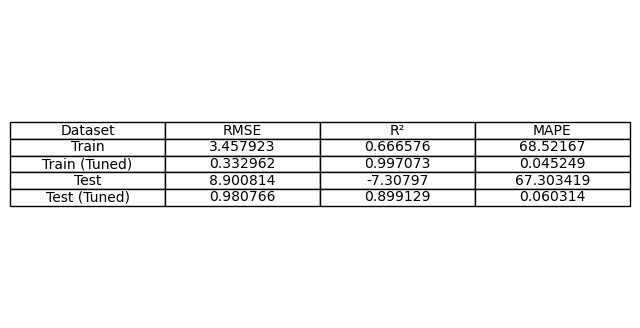

In [113]:
# Comparison table
data = {
    "Dataset": ["Train", "Train (Tuned)", "Test", "Test (Tuned)"],
    "RMSE": [3.457923, 0.332962, 8.900814, 0.980766],
    "R²": [0.666576, 0.997073, -7.307970, 0.899129],
    "MAPE": [68.521670, 0.045249, 67.303419, 0.060314]
}

df_comparison = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=df_comparison.values, colLabels=df_comparison.columns, cellLoc="center", loc="center")

table.auto_set_font_size(False)
table.set_fontsize(10)

From observations, we see that:

+ Significant reduction in RMSE: The RMSE for both the train and test sets has drastically decreased (Train: 3.46 → 0.33, Test: 8.90 → 0.98), indicating a significant improvement in prediction accuracy.

+ Drastic improvement in R²: The model now explains a much higher proportion of the variance. The test R² improved from a highly negative value (-7.31) to 0.90, showing that the model generalizes much better.

+ Huge reduction in MAPE: The percentage error has significantly decreased, especially for the train set (68.52 → 0.045) and test set (67.30 → 0.060), reflecting much better reliability in predictions.

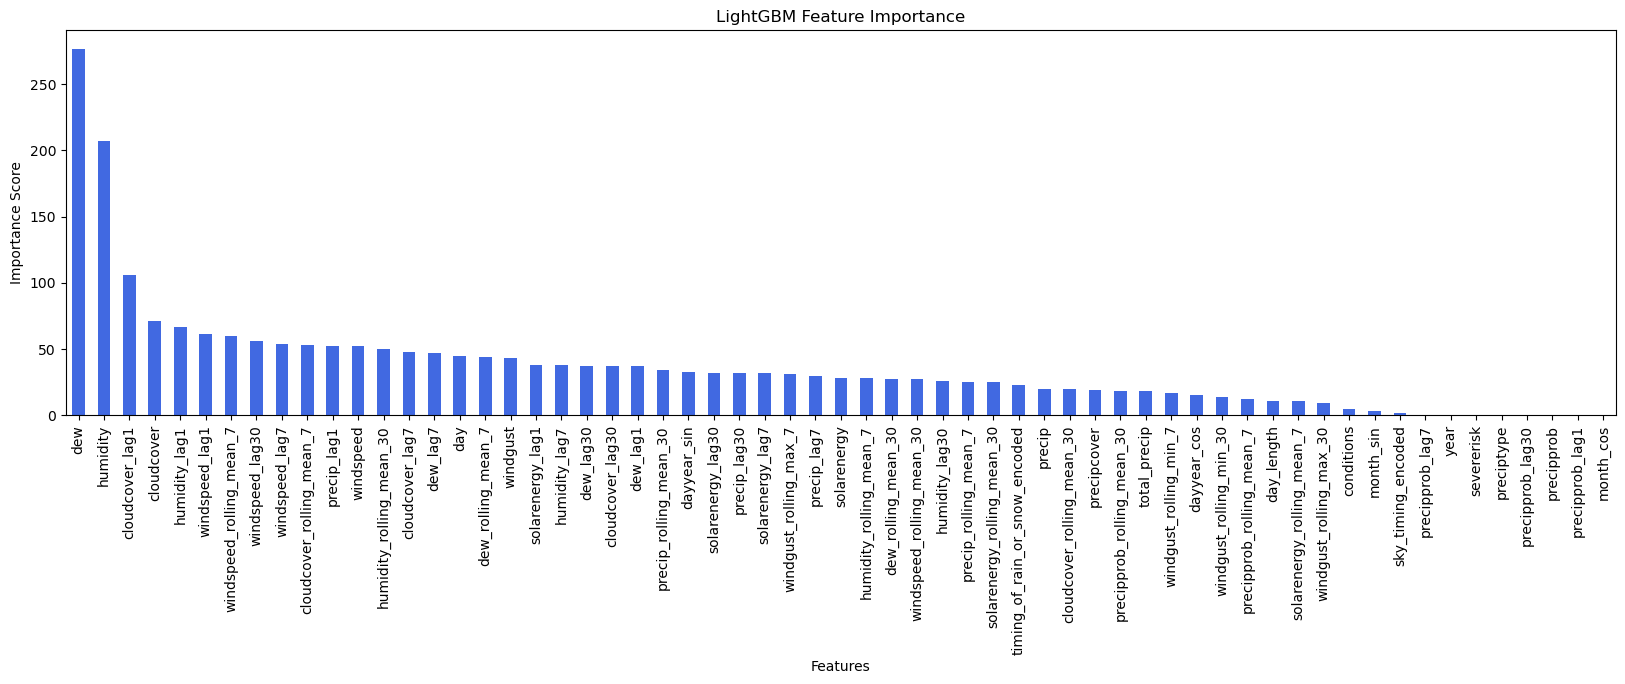

In [114]:
lgb_importance = pd.Series(best_lgb_model.feature_importances_, index=df_X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 5))
lgb_importance.plot(kind='bar', color='royalblue')
plt.title("LightGBM Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

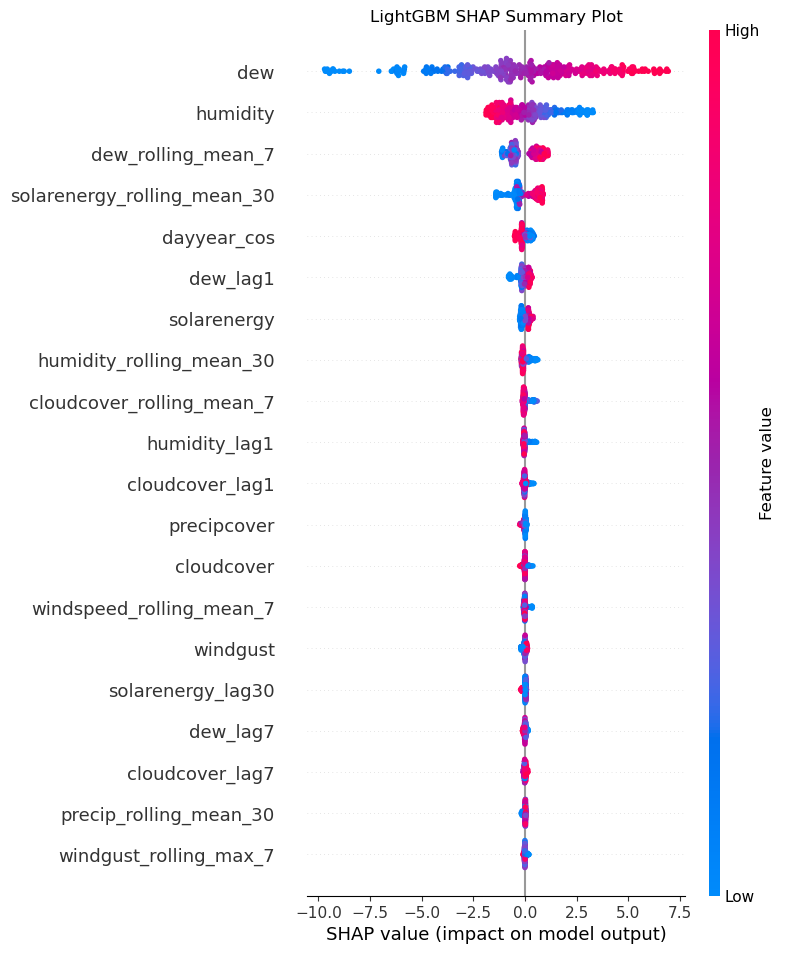

In [115]:
explainer = shap.TreeExplainer(best_lgb_model, df_X_train)
shap_values = explainer.shap_values(df_X_train, check_additivity=False)
shap.summary_plot(shap_values, df_X_train, show=False)
plt.title("LightGBM SHAP Summary Plot")
plt.show()

- The top 5 important features are dew, humidity, dew_rolling_mean_7, dayyear_cos and solarenergy_rolling_mean_30.
- The most important feature - dew - has an overwhelmingly high influence. The colors indicate a positive relationship, where lower dew point leads to lower temperature
- Humidity has quite an impact on temperature, but the relationship is negative. High temperature often has a lower humidity, while lower temperature has higher humidity
- Solarenergy_rolling_mean_30 and dew_rolling_mean_7 also has a positive influence on the data.
- Other factors has quite a small effect on temperature.

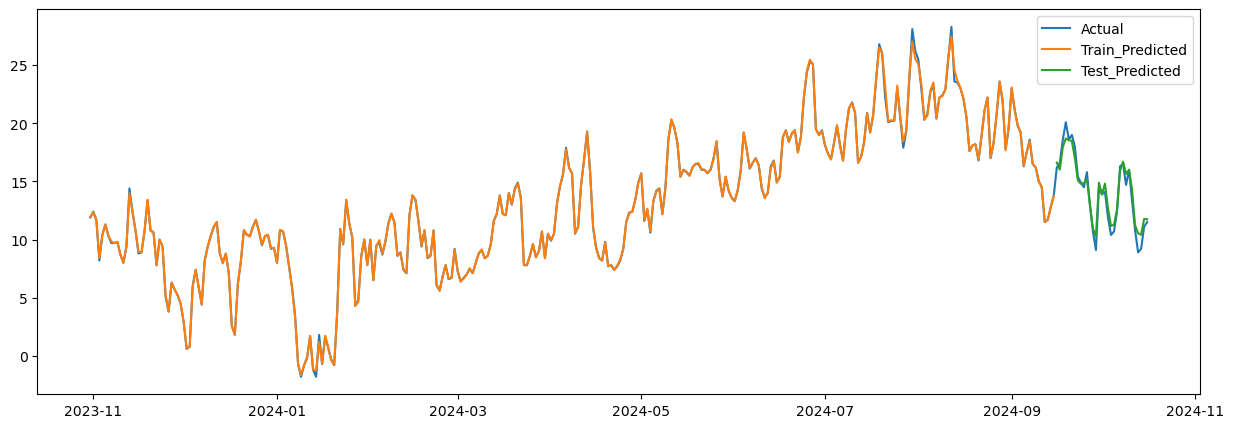

In [116]:
plt.figure(figsize = (15,5))
plt.plot(df.index, df['temp'], label='Actual')
plt.plot(df_y_train.index, opt_train_preds, label='Train_Predicted')
plt.plot(df_y_test.index, opt_test_preds, label='Test_Predicted')
plt.legend()
plt.show()

##**Random Forest**##

In [117]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(df_X_train, df_y_train)

train_preds_rf = rf_model.predict(df_X_train)
test_preds_rf = rf_model.predict(df_X_test)

train_r2_rf = r2_score(df_y_train, train_preds_rf)
test_r2_rf = r2_score(df_y_test, test_preds_rf)
train_mse_rf = mean_squared_error(df_y_train, train_preds_rf)
test_mse_rf = mean_squared_error(df_y_test, test_preds_rf)

print(f"Random Forest - Train R²: {train_r2_rf:.4f}, Test R²: {test_r2_rf:.4f}")
print(f"Random Forest - Train MSE: {train_mse_rf:.4f}, Test MSE: {test_mse_rf:.4f}")

Random Forest - Train R²: 0.9948, Test R²: 0.3116
Random Forest - Train MSE: 0.1967, Test MSE: 6.5650


In [118]:
def rf_tuning(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'max_depth': trial.suggest_int("max_depth", 10, 50),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
        'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        'bootstrap': trial.suggest_categorical("bootstrap", [True, False])
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(df_X_train, df_y_train)

    preds = model.predict(df_X_test)
    mse = mean_squared_error(df_y_test, preds)
    return mse

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(rf_tuning, n_trials=50)

best_rf_params = study_rf.best_params
print("Best parameters found for Random Forest:", best_rf_params)

best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf_model.fit(df_X_train, df_y_train)

rf_pred_train = best_rf_model.predict(df_X_train)
rf_pred_test = best_rf_model.predict(df_X_test)

rf_train_r2 = r2_score(df_y_train, rf_pred_train)
rf_test_r2 = r2_score(df_y_test, rf_pred_test)
rf_train_rmse = root_mean_squared_error(df_y_train, rf_pred_train)
rf_test_rmse = root_mean_squared_error(df_y_test, rf_pred_test)
rf_train_mape = mean_absolute_percentage_error(df_y_train, rf_pred_train)
rf_test_mape = mean_absolute_percentage_error(df_y_test, rf_pred_test)
rf_train_mse = mean_squared_error(df_y_train, rf_pred_train)
rf_test_mse = mean_squared_error(df_y_test, rf_pred_test)

result = pd.DataFrame({'Train': [rf_train_r2, rf_train_rmse, rf_train_mape, rf_train_mse],
                       'Test': [rf_test_r2, rf_test_rmse, rf_test_mape, rf_test_mse]},
                       index = ['R²', 'RMSE','MAPE', 'MSE'])
result

Best parameters found for Random Forest: {'n_estimators': 134, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}


,Train,Test
R²,0.976804,0.669233
RMSE,0.937256,1.776003
MAPE,0.171620,0.112324
MSE,0.878448,3.154185


For the Random Forest model, we fine-tuned key hyperparameters to optimize performance and generalization:

- n_estimators (50–500): Controls the number of trees. More trees improve stability but increase computation time, so we set a reasonable range. At first we try: 10–1000 but too wide, consuming too much memory , cpu/ram unavailability.
- max_depth (10–50): Limits tree depth to avoid overly complex models that overfit. A minimum of 10 ensures useful splits, while 50 prevents excessive depth.
- min_samples_split (2–10): Defines the minimum number of samples needed to split a node. Lower values allow more splits, while higher values reduce overfitting.
- min_samples_leaf (1–10): Sets the minimum samples per leaf. A small value (1) captures fine details, while a larger value (10) adds regularization.
- max_features ("sqrt", "log2"):Controls how many features are considered at each split. "sqrt" is a common choice for balance, while "log2" restricts complexity.
- bootstrap (True, False): When True, each tree trains on a random subset of the data, improving generalization. False may help in some cases but risks overfitting.

With optuna , we set direction='minimize' --> trying to minimize an objective function then runs the optimization process for 50 trials. We calculate several evaluation metrics for both the training and test sets : RMSE, MAPE, R-squared , MSE to measure accuracy and error.

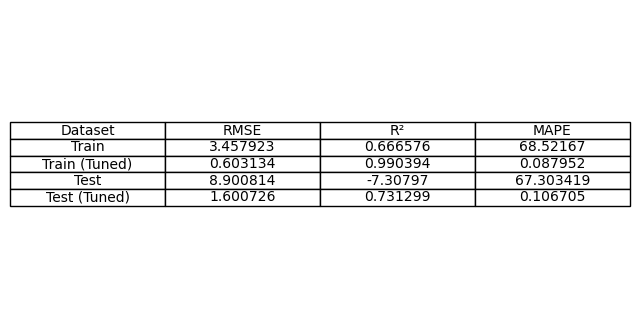

In [ ]:
# Comparison table
data = {
    "Dataset": ["Train", "Train (Tuned)", "Test", "Test (Tuned)"],
    "RMSE": [3.457923, 00.937256, 8.900814, 1.776003],
    "R²": [0.666576, 0.976804, -7.307970, 0.669233],
    "MAPE": [68.521670, 0.878448, 67.303419, 3.154185]
}

df_comparison = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=df_comparison.values, colLabels=df_comparison.columns, cellLoc="center", loc="center")

table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()

From observations, we see that :
- Significant reduction in RMSE → The error has significantly decreased, indicating improved prediction accuracy.
- Drastic improvement in R² → The model now explains a much higher proportion of the variance, especially for the test set, where the previous R² value was highly negative.
- Huge reduction in MAPE → The percentage error has drastically decreased, reflecting much better prediction reliability.

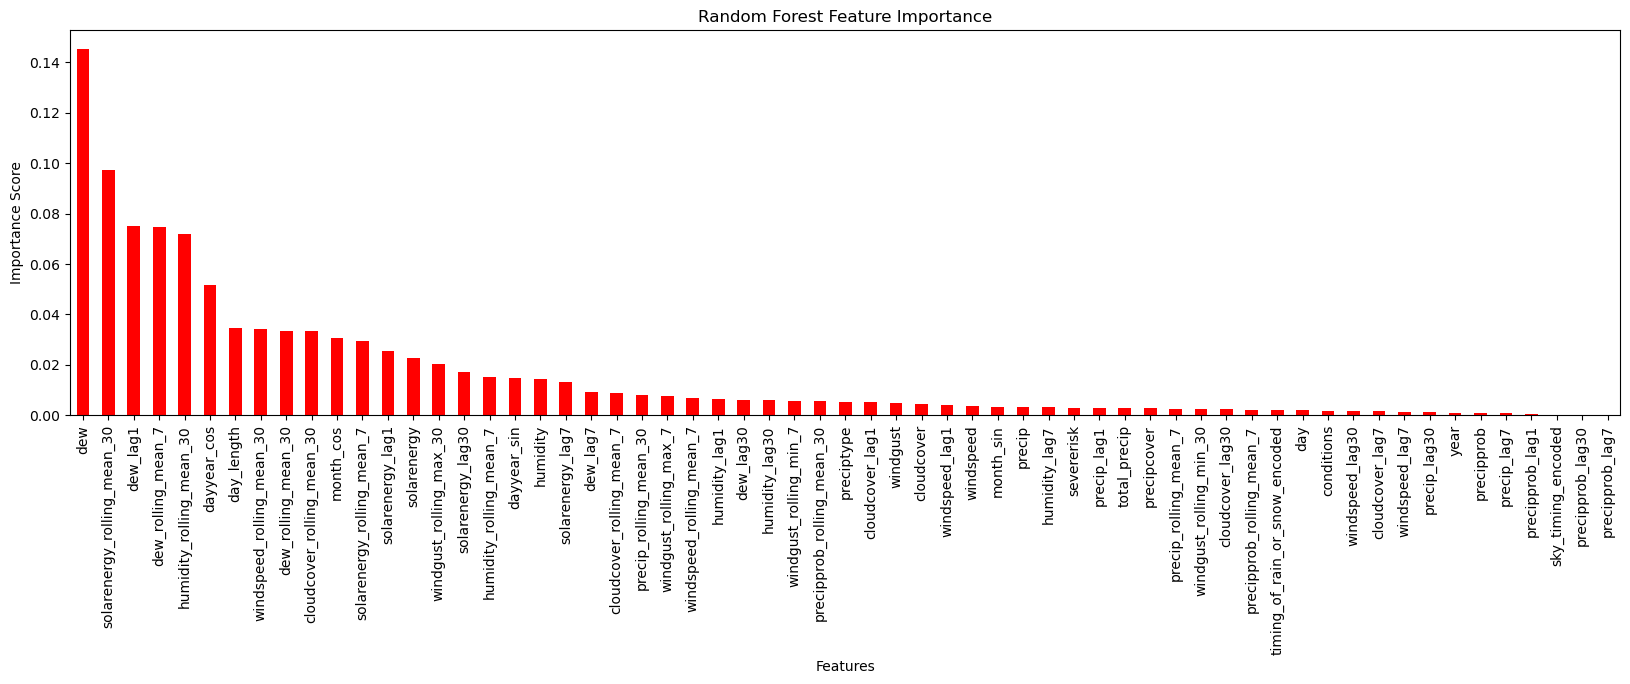

In [120]:
rf_importance = pd.Series(best_rf_model.feature_importances_, index=df_X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 5))
rf_importance.plot(kind='bar', color='red')
plt.title("Random Forest Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

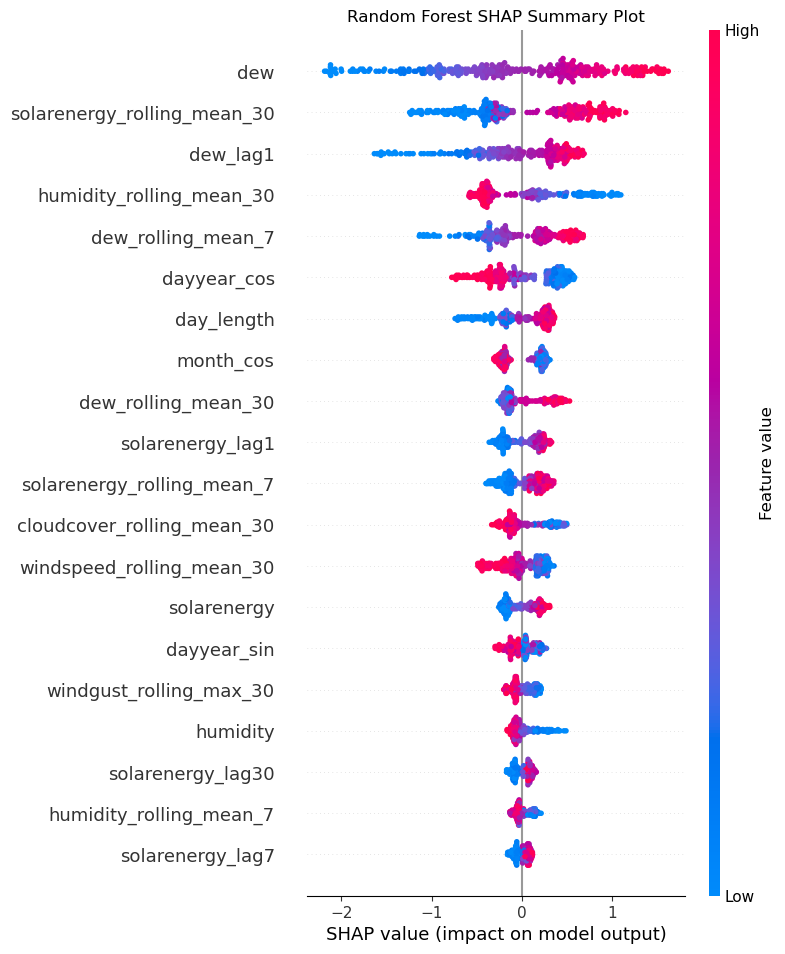

In [121]:
explainer = shap.TreeExplainer(best_rf_model, df_X_train)
shap_values = explainer.shap_values(df_X_train, check_additivity=False)
shap.summary_plot(shap_values, df_X_train, show=False)
plt.title("Random Forest SHAP Summary Plot")
plt.show()

Random Forest shows a more balanced importance distribution:
- Dew is still the most influential with a positive relationship
- solarenergy_rolling_mean_30, humidity_rolling_mean_30 and dew_lag_1 has more impact than top 4 most important features in LightGBM. solarenergy_rolling_mean_30, dew_lag_1 has positive relationships, and humidity_rolling_mean_30 has a negative relationship.


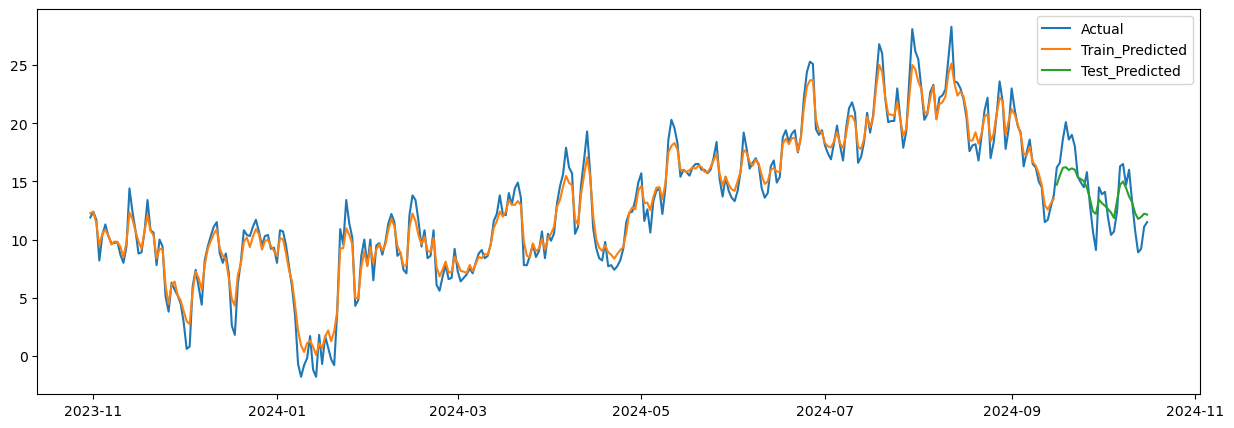

In [122]:
plt.figure(figsize = (15,5))
plt.plot(df.index, df['temp'], label='Actual')
plt.plot(df_y_train.index, rf_pred_train, label='Train_Predicted')
plt.plot(df_y_test.index, rf_pred_test, label='Test_Predicted')
plt.legend()
plt.show()

#**Training Weekly Model**#

In [123]:
weekly_df = preprocess_x(weekly_df)
weekly_df = feature_engineering(weekly_df, weekly=True)

weekly_df = weekly_df.iloc[30:]

df_train = weekly_df.loc[weekly_df.index <= '2024-09-15']
df_test = weekly_df.loc[weekly_df.index > '2024-09-15']

df_X_train = df_train.drop('temp', axis = 1)
df_y_train = df_train['temp']

df_X_test = df_test.drop('temp', axis = 1)
df_y_test = df_test['temp']

##**LightGBM**##

In [124]:
model = lgb.LGBMRegressor(verbosity=-1, random_state=42)

model.fit(df_X_train, df_y_train)

train_preds = model.predict(df_X_train)
test_preds = model.predict(df_X_test)

train_r2 = r2_score(df_y_train, train_preds)
test_r2 = r2_score(df_y_test, test_preds)
train_mse = mean_squared_error(df_y_train, train_preds)
test_mse = mean_squared_error(df_y_test, test_preds)

print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

Train R²: 0.9970, Test R²: 0.9179
Train MSE: 0.1120, Test MSE: 0.7825


In [125]:
#Tuning LightGBM

study = optuna.create_study(direction='minimize')
study.optimize(lgb_tuning, n_trials=50)

best_lgb_params = study.best_params
print("Best parameters found:", best_lgb_params)

best_lgb_model = lgb.LGBMRegressor(**best_lgb_params, random_state=42)
best_lgb_model.fit(df_X_train, df_y_train)

opt_train_preds = best_lgb_model.predict(df_X_train)
opt_test_preds = best_lgb_model.predict(df_X_test)

opt_train_r2 = r2_score(df_y_train, opt_train_preds)
opt_test_r2 = r2_score(df_y_test, opt_test_preds)
opt_train_rmse = root_mean_squared_error(df_y_train, opt_train_preds)
opt_test_rmse = root_mean_squared_error(df_y_test, opt_test_preds)
opt_train_mape = mean_absolute_percentage_error(df_y_train, opt_train_preds)
opt_test_mape = mean_absolute_percentage_error(df_y_test, opt_test_preds)
opt_train_mse = mean_squared_error(df_y_train, opt_train_preds)
opt_test_mse = mean_squared_error(df_y_test, opt_test_preds)

result = pd.DataFrame({'Train': [opt_train_r2, opt_train_rmse, opt_train_mape, opt_train_mse],
                       'Test': [opt_test_r2, opt_test_rmse, opt_test_mape, opt_test_mse]},
                       index = ['R²', 'RMSE','MAPE', 'MSE'])
result

Best parameters found: {'num_leaves': 165, 'max_depth': 11, 'learning_rate': 0.01780755946699428, 'n_estimators': 437, 'min_data_in_leaf': 12, 'feature_fraction': 0.6680802308118345, 'bagging_fraction': 0.8691736727335333, 'bagging_freq': 3, 'reg_alpha': 3.0746985912920836e-05, 'reg_lambda': 8.203956274959869e-05}


,Train,Test
R²,0.998516,0.929907
RMSE,0.237038,0.817559
MAPE,0.026115,0.048873
MSE,0.056187,0.668403


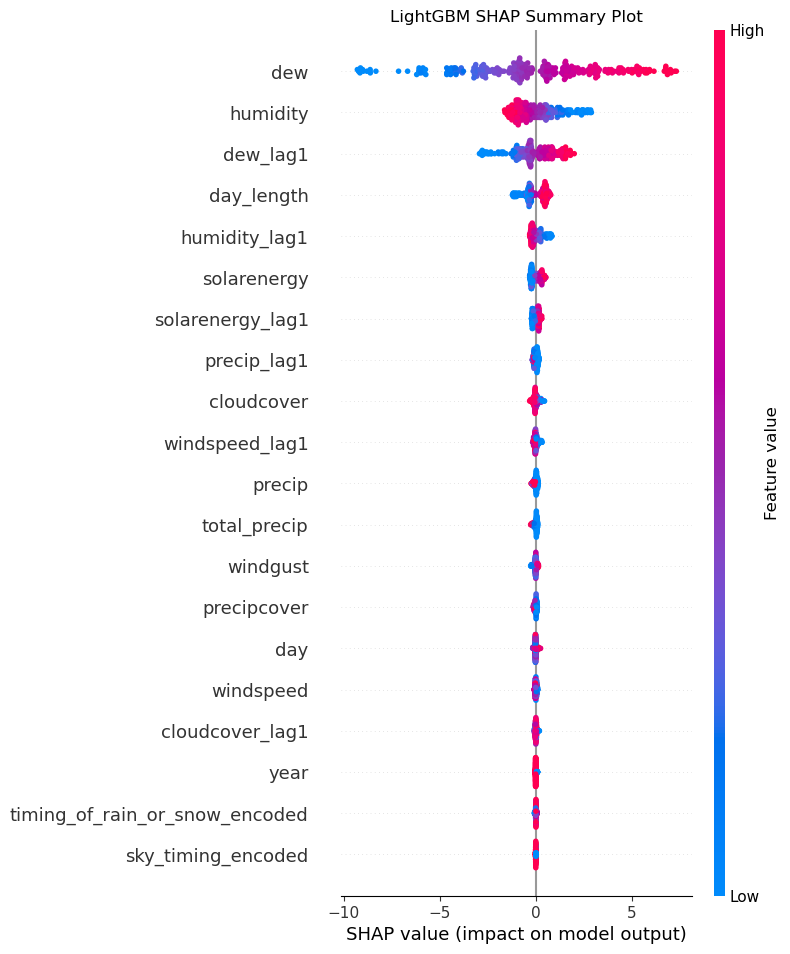

In [126]:
explainer = shap.TreeExplainer(best_lgb_model, df_X_train)
shap_values = explainer.shap_values(df_X_train, check_additivity=False)
shap.summary_plot(shap_values, df_X_train, show=False)
plt.title("LightGBM SHAP Summary Plot")
plt.show()


-  "dew," "humidity," "dew_lag1", etc.. are the most important in predicting the target variable.
Features lower in the list contribute less to the model’s decisions.
	- Look at the chart, the blue are on the left. It means that
	lower value decreases temperature. In contrast, the red are on right
	the higher value increase the temp.
	- This means higher humidity (red) tends to decrease the model’s prediction,
	while lower humidity (blue) tends to increase the model’s prediction.




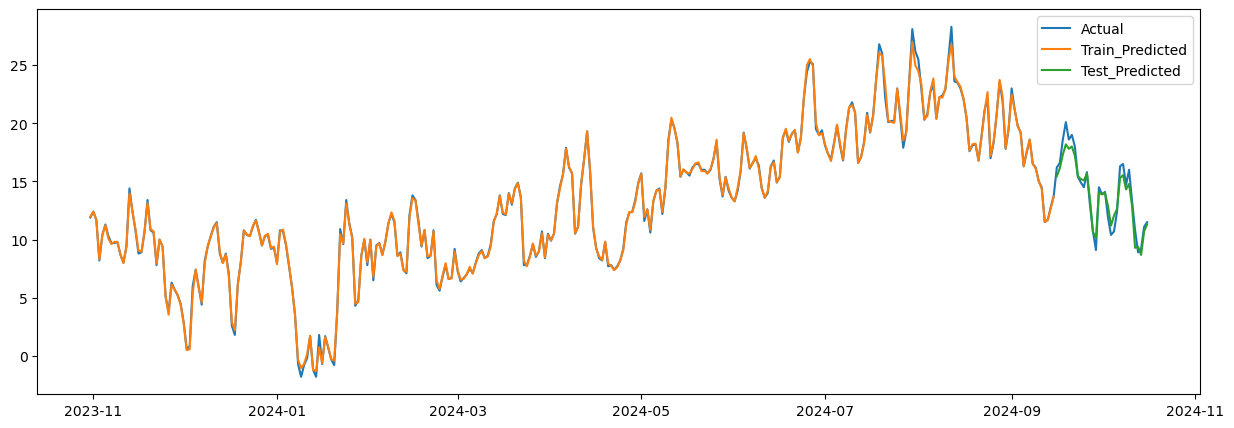

In [127]:
plt.figure(figsize = (15,5))
plt.plot(weekly_df.index, weekly_df['temp'], label='Actual')
plt.plot(df_y_train.index, opt_train_preds, label='Train_Predicted')
plt.plot(df_y_test.index, opt_test_preds, label='Test_Predicted')
plt.legend()
plt.show()

##**Random Forest**##

In [128]:
#Tuning
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(rf_tuning, n_trials=50)

best_rf_params = study_rf.best_params
print("Best parameters found for Random Forest:", best_rf_params)

best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf_model.fit(df_X_train, df_y_train)

rf_pred_train = best_rf_model.predict(df_X_train)
rf_pred_test = best_rf_model.predict(df_X_test)

rf_pred_train = best_rf_model.predict(df_X_train)
rf_pred_test = best_rf_model.predict(df_X_test)

rf_train_r2 = r2_score(df_y_train, rf_pred_train)
rf_test_r2 = r2_score(df_y_test, rf_pred_test)
rf_train_rmse = root_mean_squared_error(df_y_train, rf_pred_train)
rf_test_rmse = root_mean_squared_error(df_y_test, rf_pred_test)
rf_train_mape = mean_absolute_percentage_error(df_y_train, rf_pred_train)
rf_test_mape = mean_absolute_percentage_error(df_y_test, rf_pred_test)
rf_train_mse = mean_squared_error(df_y_train, rf_pred_train)
rf_test_mse = mean_squared_error(df_y_test, rf_pred_test)

result = pd.DataFrame({'Train': [rf_train_r2, rf_train_rmse, rf_train_mape, rf_train_mse],
                       'Test': [rf_test_r2, rf_test_rmse, rf_test_mape, rf_test_mse]},
                       index = ['R²', 'RMSE','MAPE', 'MSE'])
result

Best parameters found for Random Forest: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}


,Train,Test
R²,0.978865,0.822823
RMSE,0.894650,1.299830
MAPE,0.172750,0.075792
MSE,0.800400,1.689558


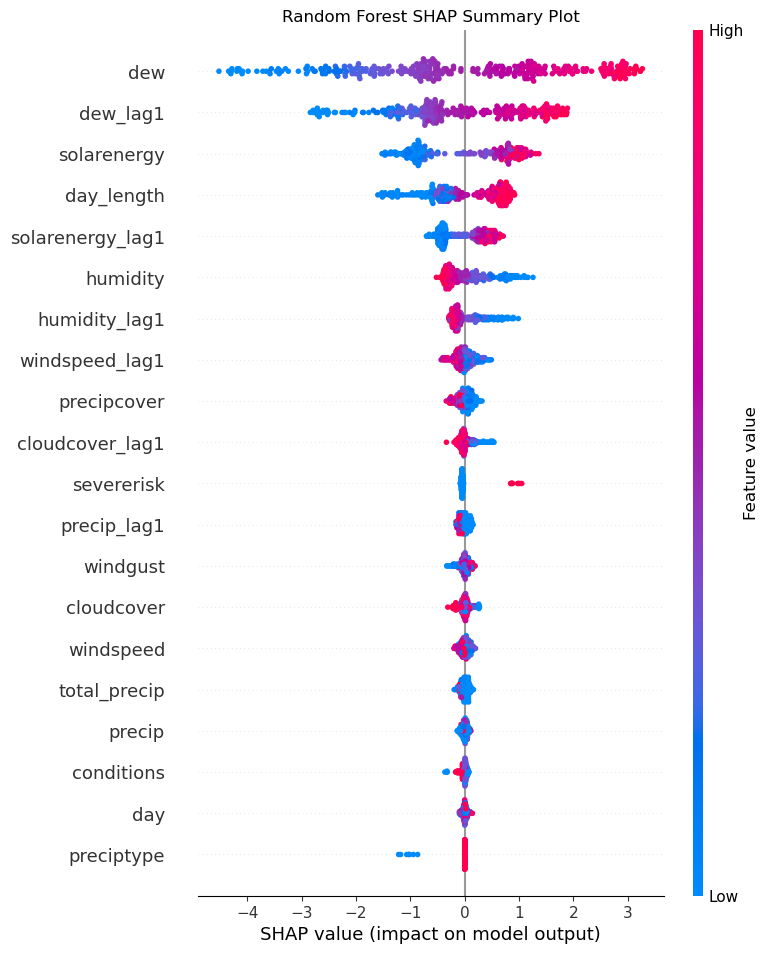

In [129]:
explainer = shap.TreeExplainer(best_rf_model, df_X_train)
shap_values = explainer.shap_values(df_X_train, check_additivity=False)
shap.summary_plot(shap_values, df_X_train, show=False)
plt.title("Random Forest SHAP Summary Plot")
plt.show()

- Dew is still the most important variable but Random Forest appears to give more weight to dew_lag1 than LightGBM does.=> The Random Forest model primarily relies on dew, solar energy, humidity, and day length to make predictions.

- The amount of solar energy received and its past values have significant effects. The spread of SHAP values suggests that this feature has varying influence in different instances.

- Many other features have tightly clustered SHAP values around zero such as severerisk, day, preciptype, etc.




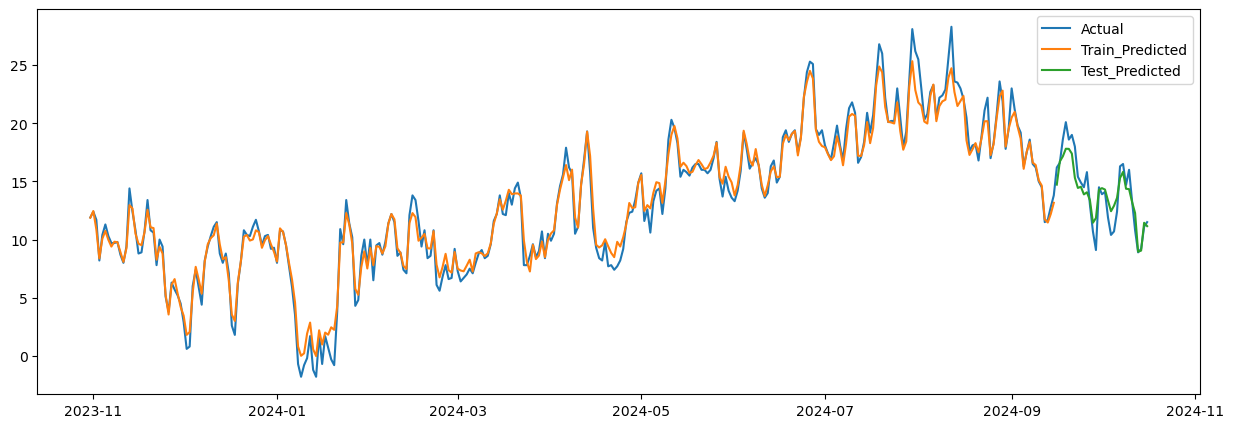

In [130]:
plt.figure(figsize = (15,5))
plt.plot(weekly_df.index, weekly_df['temp'], label='Actual')
plt.plot(df_y_train.index, rf_pred_train, label='Train_Predicted')
plt.plot(df_y_test.index, rf_pred_test, label='Test_Predicted')
plt.legend()
plt.show()

##**Comparison of Daily and Weekly Models**##

I. Results

1. LightGBM

- The weekly model performs better across all metrics in terms of accuracy and overall performance.

2. Random Forest

- The daily model has higher accuracy on the training set but suffers from significant overfitting. The weekly model has lower accuracy on the training set but generalizes better, performing better than the daily model on the test set. The weekly model of Random Forest outperforms the daily model.

- Compared to LightGBM, Random Forest has a lower test R² in both daily & weekly versions, indicating that LightGBM performs better for this problem.



II. Comparison of How the Two Models Work

1. Feature Engineering


1.1. Daily Model

- Time-based features such as month_sin, month_cos, dayyear_sin, dayyear_cos are created

- Rolling window statistics (max/min, lag) are computed for 7, and 30 days for variables like dew, humidity, precip, precipprob, windspeed, cloudcover, and solarenergy.

→ The daily model captures short-term and long-term trends using rolling statistics (7-day and 30-day moving averages).

→ The daily model utilizes more rolling and lagged features, making it more complex and increasing the risk of overfitting to the training data.

1.2. Weekly Model

- Does not generate month_sin, month_cos, dayyear_sin, dayyear_cos features.

- Computes only lag-1 for variables like dew, humidity, precip, precipprob, windspeed, cloudcover, and solarenergy.

→ The weekly model aggregates data by week, allowing it to capture broader climate trends without being overly affected by daily fluctuations in temperature.

→ The weekly model only uses lag-1 features, reducing dependency on random fluctuations.

2. Noise Level in the Data

- Daily forecasting is more affected by random fluctuations, as temperature can change unpredictably due to factors like storms, strong winds, or sudden weather events. These fluctuations make forecasting more challenging.

- In contrast, the weekly model reduces noise by focusing on long-term trends rather than daily variations. By aggregating data on a weekly basis, random fluctuations are smoothed out, making it easier for the model to learn patterns.

3. Overfitting & Generalization Ability

- The daily model is more prone to overfitting due to its large number of features and the high variability in the data. This results in high performance on the training set but significantly lower performance on the test set.

- The weekly model generalizes better (higher test R²), meaning it performs better on unseen data.

III. Which Model Should Be Used for Forecasting

- The weekly model is preferable if the goal is to predict temperature with the highest accuracy.

- Howeve, if you need daily temperature forecasts for applications requiring high temporal granularity, use the daily model. If you need long-term temperature trends, use the weekly model.